In [59]:
test

,Y
Date,
2021-12-06,36.0
2021-01-02,33.0
2021-01-02,56.0
2021-01-02,21.0
2021-01-02,60.0
...,...
2021-12-30,25.0
2021-12-29,22.0
2021-12-29,53.0


TypeError: cannot do slice indexing on RangeIndex with these indexers [2021-01-01] of type str

In [23]:
import pandas as pd

data = pd.read_csv('/workspaces/COBI/Arribos2017-2021.csv')

# group by especie and unidad_economica
data = data[data['especie'].str.contains('LANGOSTA')]
data = data.groupby(['especie', 'unidad_economica']).count().sort_values(by=['peso_desembarcado'], ascending=False)[['peso_desembarcado']]
data

peso_desembarcado
especie                  unidad_economica                                                     
LANGOSTA ROJA ENT. FCA.  LITORAL DE BAJA CALIFORNIA S DE PR DE RL                         4982
                         SCPP ENSENADA SCL                                                 490
                         UP BUZOS DE LA COSTA OCCIDENTAL DE BC S DE RL D...                397
                         PESCADORES Y BUZOS RIBEREÑOS DE MANCHURIA, S.A....                389
                         SCPP PESCADORES NACIONALES DE ABULON SC DE RL                     343
...                                                                                        ...
LANGOSTA ROJA COLAS DE   LITORAL DE BAJA CALIFORNIA S DE PR DE RL                            1
                         PESCADORES EL CHUTE SPR DE RL                                       1
                         PESCADORES Y BUZOS RIBEREÑOS DE MANCHURIA, S.A....                  1
                         PESQUERA PUERTO ENSENADA S DE PR DE RL                              1
LANGOSTA TENAZAS DE FCA. LITORAL DE BAJA CALIFORNIA S DE PR DE RL                            1

[69 rows x 1 columns]

# Baseline

## Statsmodel

/tmp/ipykernel_6103/2306120779.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arima_data.sort_values(by=['Date'], inplace=True)
/workspaces/COBI/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/workspaces/COBI/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/workspaces/COBI/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

/workspaces/COBI/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/COBI/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/workspaces/COBI/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE: 263.4974510971951


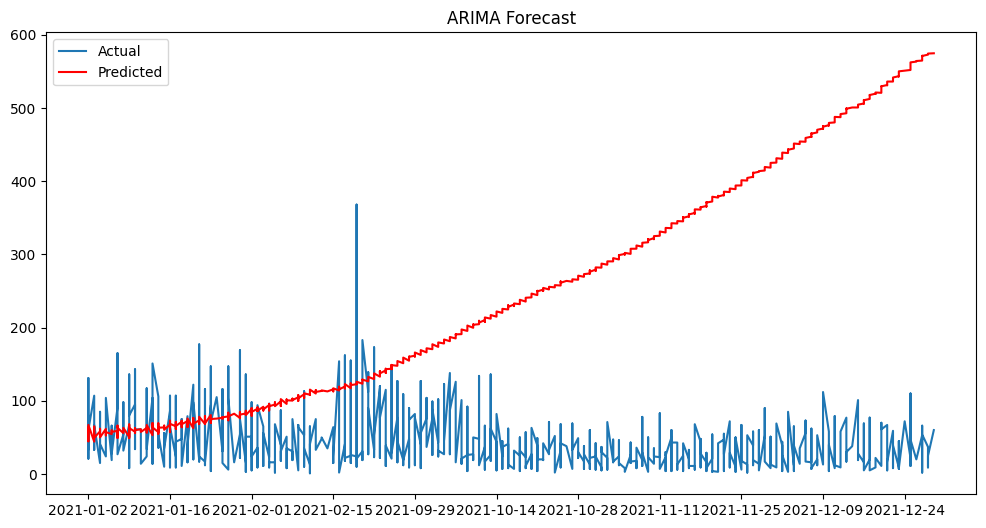

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load your dataset
data = pd.read_csv('/workspaces/COBI/Arribos2017-2021.csv')
# Filter by 'especie' and 'unidad_economica'
filtered_data = data[(data['especie'].str.contains('LANGOSTA')) & (data['unidad_economica'] == 'LITORAL DE BAJA CALIFORNIA S DE PR DE RL')]
# Adapt to ARIMA model
arima_data = filtered_data[['periodo_fin', 'peso_desembarcado']]
# Rename columns to Date and Y
arima_data.columns = ['Date', 'Y']
# Order by Date
arima_data.sort_values(by=['Date'], inplace=True)
# We take the sum of the values for each date
arima_data.groupby('Date').sum()

pd.to_datetime(arima_data['Date'])
arima_data.set_index('Date', inplace=True)

# Perform any necessary data transformations here, if needed
# For example, you can take the log of 'Y' if the data is not stationary
# data['Y'] = np.log(data['Y'])

# Split the data into training and testing sets (SLICED at 2021-01-01)
# the Date column is datetime
train = arima_data[arima_data.index <= '2021-01-01']
test = arima_data[arima_data.index >= '2021-01-01']

# ARIMA values
p = 5  # AR value
d = 3  # differencing value
q = 7  # MA value

# Fit an ARIMA model
order = (p, d, q)  # Define your order (p, d, q) values
model = ARIMA(train, order=order)
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Calculate RMSE (Root Mean Squared Error) to evaluate the model
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

# Plot the original data and predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Y'], label='Actual')
# Only show every two weeks in the x-axis
plt.xticks(np.arange(0, len(test), 14))
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()


In [85]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from mango import scheduler, Tuner

def arima_objective_function(args_list):
    global data_values
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            trend = params['trend']
            
            model = ARIMA(data_values, order=(p,d,q), trend = trend)
            predictions = model.fit()
            mse = mean_squared_error(data_values, predictions.fittedvalues)   
            params_evaluated.append(params)
            results.append(mse)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(1e5)
        
        #print(params_evaluated, mse)
    return params_evaluated, results

param_space = dict(p= range(0, 30),
                   d= range(0, 30),
                   q =range(0, 30),
                   trend = ['n', 'c', 't', 'ct']
                  )

conf_Dict = dict()
conf_Dict['num_iteration'] = 200
data_values = list(arima_data['Y'])
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

Best score: 15400.085171067984: 100%|██████████| 200/200 [2:25:07<00:00, 43.54s/it]   

best parameters: {'d': 0, 'p': 14, 'q': 4, 'trend': 'c'}
best loss: 15400.085171067984
